In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [2]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()

In [3]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [4]:
# build the dataset

block_size = 6 # context length: how many characters do we take to predict the next one?
X, Y = [], []
for w in words[:5]:
  
  #print(w)
  context = [0] * block_size
  for ch in w + '.':
    ix = stoi[ch]
    X.append(context)
    Y.append(ix)
    #print(''.join(itos[i] for i in context), '--->', itos[ix])
    context = context[1:] + [ix] # crop and append
  
X = torch.tensor(X)
Y = torch.tensor(Y)

In [5]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([32, 6]), torch.int64, torch.Size([32]), torch.int64)

In [6]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [7]:
Xtr.shape, Ytr.shape #Dataset

(torch.Size([182625, 3]), torch.Size([182625]))

In [8]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 100), generator=g)
W1 = torch.randn((300, 300), generator=g)
b1 = torch.randn(300, generator=g)
W2 = torch.randn((300, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [9]:
sum(p.nelement() for p in parameters)

101127

In [10]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [11]:
for p in parameters:
  p.requires_grad = True

In [12]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [13]:
lri = []
lossi = []
stepi = []

In [14]:
for i in range(50000):
  #mini batch
  ix = torch.randint(0, Xtr.shape[0], (64,))
  #forward pass
  emb = C[Xtr[ix]]
  h = torch.tanh(emb.view(-1, 300) @ W1 + b1)
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits, Ytr[ix])
  #backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  #update
  lr = 0.1 if i<20000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad
  
  stepi.append(i)
  lossi.append(loss.log10().item())


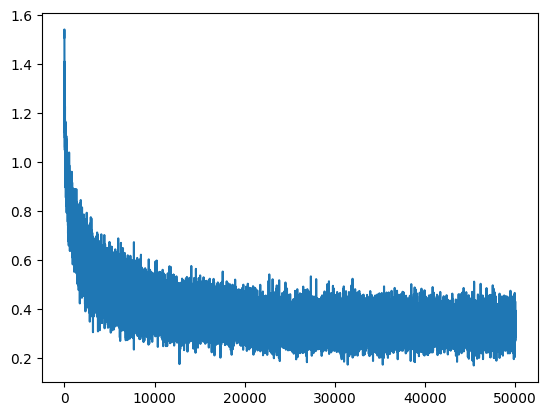

In [15]:
plt.plot(stepi, lossi)

In [16]:
emb = C[Xtr] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 300) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.1433, grad_fn=<NllLossBackward0>)

In [17]:
#training split, dev and test
#80,10,10
emb = C[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 300) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev)
loss


tensor(2.3002, grad_fn=<NllLossBackward0>)

In [18]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))

mona.
kayah.
seen.
nihayah.
remmadiendrajeriderydeelin.
shi.
jen.
eden.
van.
nar.
katelle.
kalin.
shubergiagonest.
jair.
jennox.
thonoch.
zeyne.
rya.
juliel.
yuva.
